## Partie 1 : Exploration et Preparation des Donnees

### 1.1 Chargement et exploration

- Chargez le dataset et affichez ses caracteristiques principales
- Combien y a-t-il d'echantillons par classe ?
- Les classes sont-elles equilibrees ?

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

Entre 174 et 183 valeurs par classe


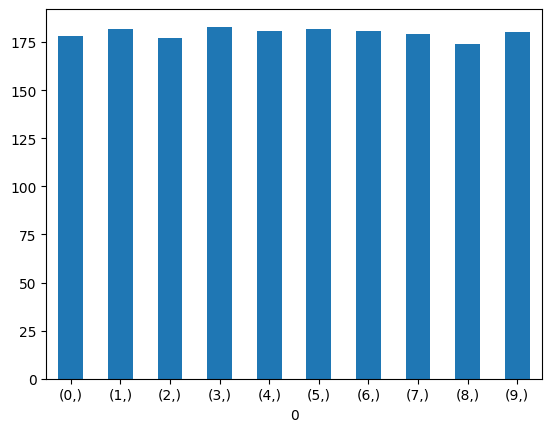

In [2]:
import pandas as pd

df_y = pd.DataFrame(y)

df_y.value_counts().sort_index().plot(kind="bar", rot=0)
print(
    f"Entre {df_y.value_counts().min()} et {df_y.value_counts().max()} valeurs par classe"
)

- Classes équilibrées

### 1.2 Visualisation des images

- Affichez une grille de 25 images (5x5) avec leurs labels
- Utilisez `plt.imshow()` avec `cmap='gray'`
- Les images `digits.images` sont de dimension 8x8

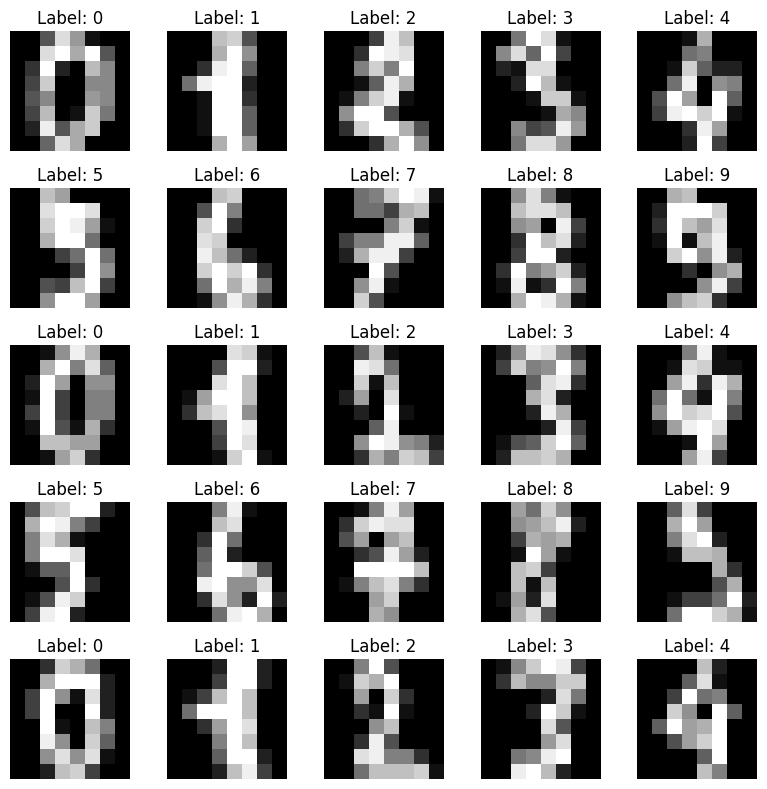

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for k in range(25):
    ax = axes[k // 5, k % 5]
    ax.imshow(digits.images[k], cmap="gray")
    ax.set_title(f"Label: {digits.target[k]}")
    ax.set_axis_off()
plt.tight_layout()

### 1.3 Preparation

- Divisez les donnees en train (80%) et test (20%)
- Utilisez `stratify=y` pour conserver la distribution des classes
- Normalisez les donnees avec `StandardScaler`

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2, stratify=y
)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

## Partie 2 : Classification avec KNN

### 2.1 Premier modele

- Entrainez un KNN avec K=5, n_jobs=-1, algorithm='kd_tree'
- Evaluez avec accuracy et rapport de classification

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "clasifier",
            KNeighborsClassifier(n_neighbors=5, n_jobs=-1, algorithm="kd_tree"),
        ),
    ],
)

In [7]:
from sklearn.metrics import accuracy_score, classification_report
import time

start_time = time.time()
knn_pipeline.fit(X_train, y_train)
end_time = time.time()

y_pred_train = knn_pipeline.predict(X_train)
y_pred_test = knn_pipeline.predict(X_test)

print("Execution time: ", end_time - start_time)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))


Execution time:  0.008606433868408203
Accuracy train:  0.9839944328462074
Accuracy test:  0.9638888888888889
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      1.00      0.96        36
           2       0.95      1.00      0.97        35
           3       1.00      0.97      0.99        37
           4       0.97      0.94      0.96        36
           5       0.97      0.97      0.97        37
           6       0.97      1.00      0.99        36
           7       0.92      0.97      0.95        36
           8       0.97      0.89      0.93        35
           9       0.97      0.89      0.93        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



### 2.2 Optimisation de K

- Testez K de 1 a 20
- Tracez la courbe du score en fonction de K
- Quel est le K optimal ?

K optimal:  13


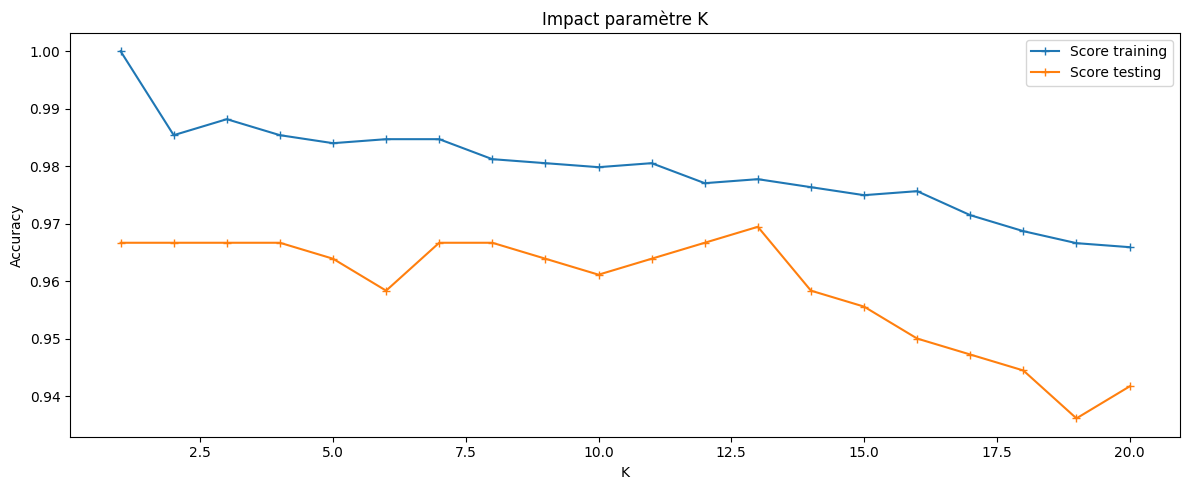

In [8]:
k_values = range(1, 21)
train_score = []
test_score = []

for k in k_values:
    knn = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                KNeighborsClassifier(n_neighbors=k, n_jobs=-1, algorithm="kd_tree"),
            ),
        ]
    )
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))

plt.figure(figsize=(12, 5))
plt.plot(k_values, train_score, label="Score training", marker="+")
plt.plot(k_values, test_score, label="Score testing", marker="+")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Impact paramètre K")
plt.legend()
plt.tight_layout()

k_optimal = test_score.index(max(test_score)) + 1
print("K optimal: ", k_optimal)

### 2.3 Analyse des erreurs

- Creez la matrice de confusion
- Visualisez-la avec `seaborn.heatmap()`

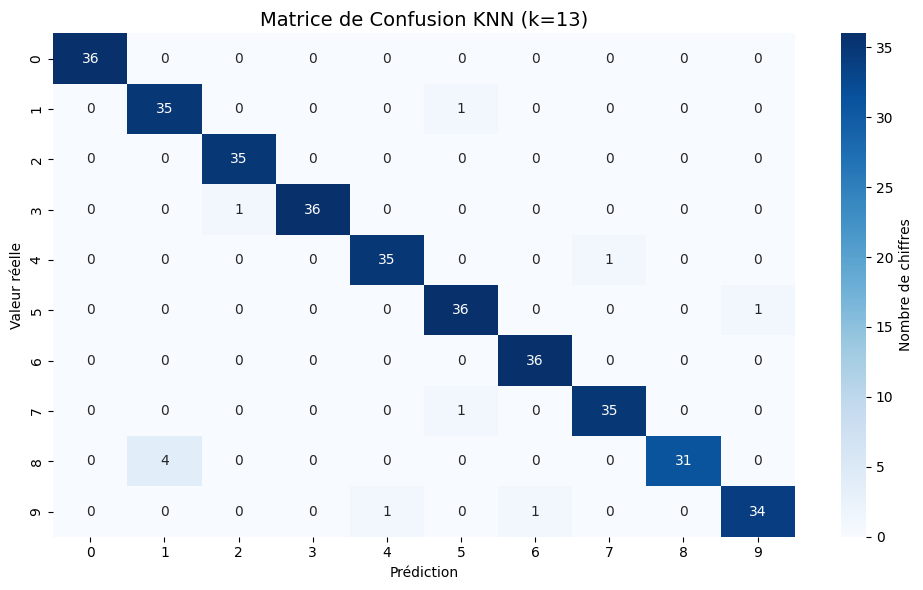

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

knn_pipeline_optimal = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            KNeighborsClassifier(n_neighbors=k_optimal, n_jobs=-1, algorithm="kd_tree"),
        ),
    ]
)

knn_pipeline_optimal.fit(X_train, y_train)
y_pred_knn_optimal = knn_pipeline_optimal.predict(X_test)

cm = confusion_matrix(y_test, y_pred_knn_optimal)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion KNN (k=13)", fontsize=14)

plt.tight_layout()

## Partie 3 : Classification avec Arbres de Decision

### 3.1 Arbre de base

- Entrainez un arbre sans contrainte
- Comparez accuracy train et test

Execution time:  0.013443946838378906
Accuracy train:  1.0
Accuracy test:  0.8166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.79      0.72      0.75        36
           2       0.82      0.77      0.79        35
           3       0.82      0.84      0.83        37
           4       0.91      0.81      0.85        36
           5       0.81      0.92      0.86        37
           6       0.77      0.83      0.80        36
           7       0.84      0.89      0.86        36
           8       0.73      0.63      0.68        35
           9       0.74      0.78      0.76        36

    accuracy                           0.82       360
   macro avg       0.82      0.82      0.81       360
weighted avg       0.82      0.82      0.82       360



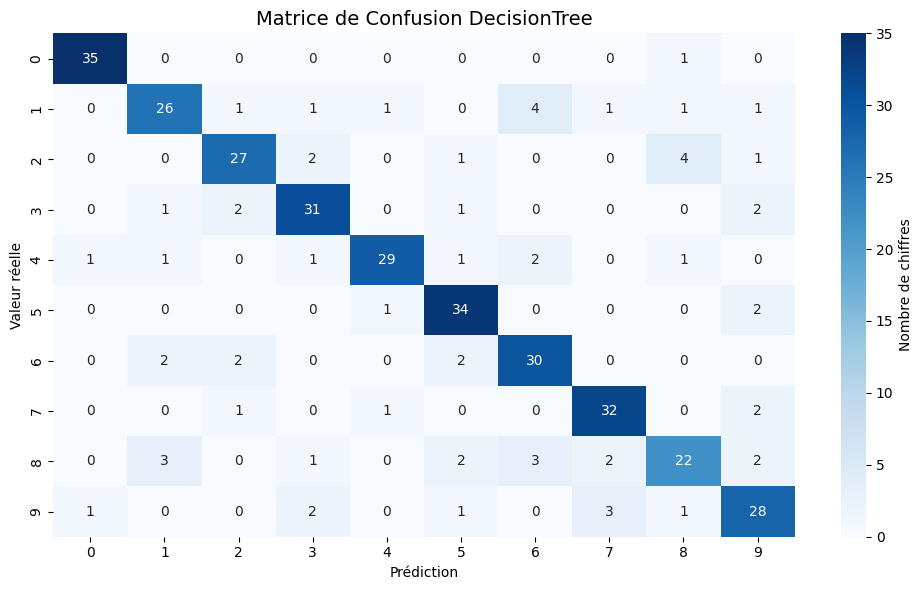

In [12]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", DecisionTreeClassifier()),
    ],
)

start_time = time.time()
dt_pipeline.fit(X_train, y_train)
end_time = time.time()

y_pred_train = dt_pipeline.predict(X_train)
y_pred_test = dt_pipeline.predict(X_test)

print("Execution time: ", end_time - start_time)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion DecisionTree", fontsize=14)

plt.tight_layout()

### 3.2 Comparaison avec KNN

- Quelle methode est meilleure sur ce probleme ?
  -> La meilleur méthode est KNN
- Quels sont les avantages et inconvenients de chaque approche ?
  -> Il semblerait que KNN n'ait aucun inconvenients ici; KNN est plus rapide et donne de meilleurs résultats que DecisionTree

## Partie 4 : Methodes d'Ensemble

### 4.1 Random Forest

- Entrainez un Random Forest avec 100 arbres
- Comparez avec l'arbre simple et KNN

Execution time:  0.19655895233154297
Accuracy train:  1.0
Accuracy test:  0.9694444444444444
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.97      0.95        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



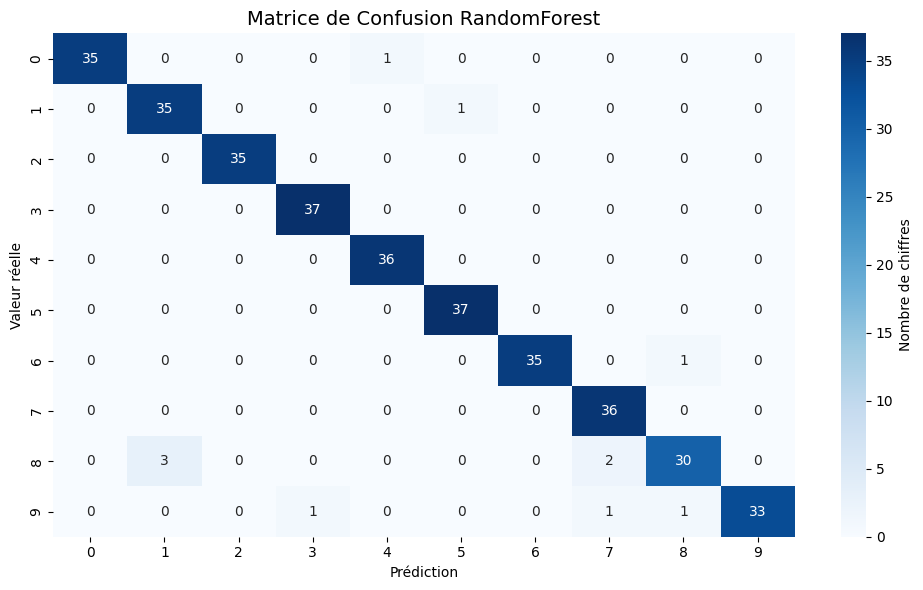

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", RandomForestClassifier()),
    ],
)

start_time = time.time()
rf_pipeline.fit(X_train, y_train)
end_time = time.time()

y_pred_train = rf_pipeline.predict(X_train)
y_pred_test = rf_pipeline.predict(X_test)

print("Execution time: ", end_time - start_time)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion RandomForest", fontsize=14)

plt.tight_layout()

- ForestTree semble meilleur de KNN

### 4.2 Gradient Boosting

- Entrainez un GradientBoostingClassifier
- Attention : peut etre lent sur ce dataset
- Comparez avec Random Forest

Execution time:  4.100892066955566
Accuracy train:  1.0
Accuracy test:  0.9555555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        36
           1       0.94      0.83      0.88        36
           2       0.97      0.97      0.97        35
           3       0.97      1.00      0.99        37
           4       1.00      0.97      0.99        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.92      1.00      0.96        36
           8       0.89      0.94      0.92        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.95       360
weighted avg       0.96      0.96      0.96       360



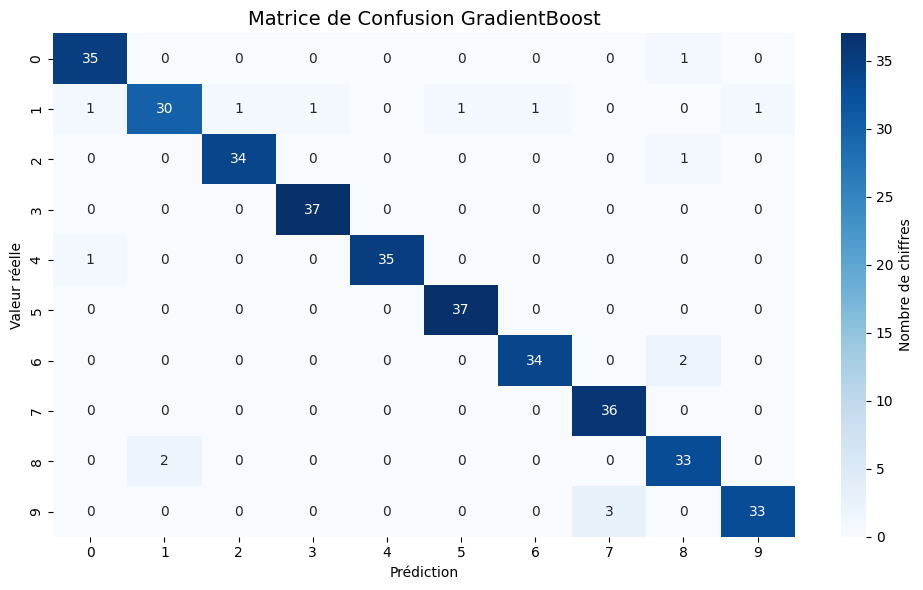

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clasifier", GradientBoostingClassifier()),
    ],
)

start_time = time.time()
gb_pipeline.fit(X_train, y_train)
end_time = time.time()

y_pred_train = gb_pipeline.predict(X_train)
y_pred_test = gb_pipeline.predict(X_test)

print("Execution time: ", end_time - start_time)
print("Accuracy train: ", accuracy_score(y_train, y_pred_train))
print("Accuracy test: ", accuracy_score(y_test, y_pred_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[f"{k}" for k in range(10)],
    yticklabels=[f"{k}" for k in range(10)],
    ax=axes,
    cbar_kws={"label": "Nombre de chiffres"},
)
axes.set_xlabel("Prédiction")
axes.set_ylabel("Valeur réelle")
axes.set_title("Matrice de Confusion GradientBoost", fontsize=14)

plt.tight_layout()

- GradientBoost ne semble pas plus performant que ForestTree

### 4.4 Voting Classifier

- Combinez vos 3 meilleurs modeles dans un VotingClassifier
- Testez `voting='hard'` et `voting='soft'`
- Le voting bat-il les modeles individuels ?